In [1]:
import math
import warnings

import geopandas as gpd
import plotnine as p
from shapely.geometry import box, shape, Point

import entwiner
import unweaver

# Suppress warnings, mostly from plotnine
warnings.filterwarnings('ignore')

WGS84 = 4326
NAD83 = 26910

In [2]:
BLUE = "#0094ff"

In [3]:
G = entwiner.DiGraphDBView(path="../artifacts/unweaver/graph.gpkg")

In [4]:
fremont_bounds = (-122.3586, 47.6470, -122.3433, 47.6554)
fremont_point = (-122.34995, 47.65060)

In [5]:
edges = G.network.edges.intersects(*fremont_bounds)
gdf = gpd.GeoDataFrame([{**e, "geometry": shape(e["geom"])} for e in edges])
gdf.crs = WGS84
gdf = gdf.to_crs(NAD83)

In [6]:
# Create base plot - showing the graph at a certain location
def base_plot(area_name):
    tmp_gdf = gpd.GeoDataFrame([{"geometry": box(*fremont_bounds)}])
    tmp_gdf.crs = WGS84
    bounds = tmp_gdf.to_crs(NAD83).total_bounds
    plot = (
        p.ggplot(gdf)
        + p.geom_map()
        + p.xlim(bounds[0], bounds[2])
        + p.ylim(bounds[1], bounds[3])
        + p.theme_void()
        + p.theme(panel_background=p.element_rect(fill="#ffffff"))
    )
    return plot

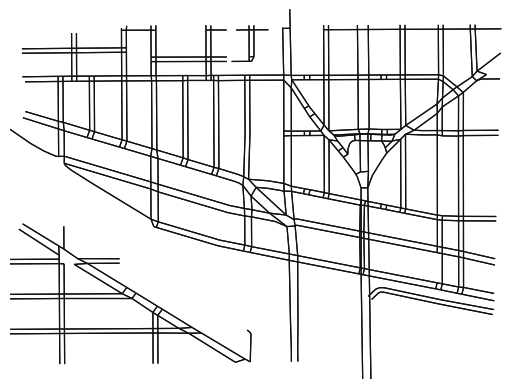

<ggplot: (8743413405995)>

In [7]:
plot = base_plot("fremont")
plot.save("../artifacts/figures/Fig1/figure_framework_base.png", dpi=180)
plot.save("../artifacts/figures/Fig1/figure_framework_base.svg", dpi=180)
plot

In [8]:
# Create plot with costs - note: this takes a very long time due to adjust_text
def weights_plot(area_name):
    plot = base_plot(area_name)
    
    gdf["weight"] = gdf["length"]
    gdf.loc[gdf["incline"] > 0.083, "weight"] = math.inf
    gdf.loc[gdf["incline"] < -0.1, "weight"] = math.inf
    gdf["center"] = gdf["geometry"].interpolate(0.5, normalized=True)
    gdf["text_x"] = gdf["center"].apply(lambda v: v.x)
    gdf["text_y"] = gdf["center"].apply(lambda v: v.y)
    gdf["text_label"] = gdf["weight"].apply(lambda v: f"{int(v) if v != math.inf else v}")
    
    # adjust_text is incredibly slow. Instead, decimate and hope for the best
    plot += p.geom_label(
            p.aes(x="text_x", y="text_y", label="text_label"), 
            data=gdf.iloc[1::15],
            size=7, 
            color=BLUE
        )

#     plot += p.geom_label(
#             p.aes(x="text_x", y="text_y", label="text_label"), 
#             size=5, 
#             color=BLUE,
#             adjust_text={
#                 'expand_points': (1.5, 1.5),
#                 'arrowprops': {
#                     'arrowstyle': '-'
#                 }
#             }
#         )
    return plot

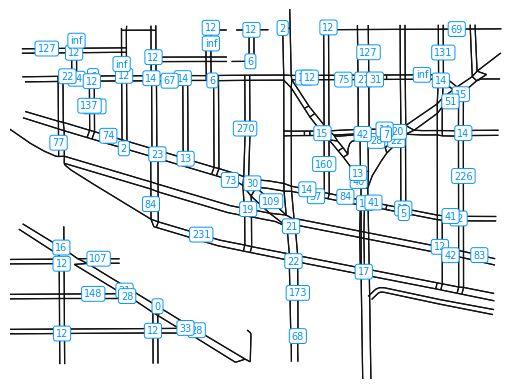

<ggplot: (8743407369141)>

In [9]:
plot = weights_plot("fremont")
plot.save("../artifacts/figures/Fig1/figure_framework_weights.png", dpi=180)
plot.save("../artifacts/figures/Fig1/figure_framework_weights.svg", dpi=180)
plot

In [10]:
def get_walkshed(area_name):
    def cost_fun(u, v, d):
        if d["incline"] is not None:
            if d["incline"] > 0.083:
                return None
            if d["incline"] < -0.1:
                return None
        return d["length"]

    candidates = unweaver.algorithms.shortest_path.waypoint_candidates(
        G, 
        fremont_point[0], 
        fremont_point[1], 
        10, 
        dwithin=10
    )
    candidate = next(candidates)
    
    G_aug = unweaver.graphs.augmented.prepare_augmented(G, candidate)
    path, edges = unweaver.algorithms.reachable.reachable(G_aug, candidate, cost_fun, 400)
    
    walkshed_gdf = gpd.GeoDataFrame([{
        **e,
        "geometry": shape(e["geom"])
    } for e in edges])
    walkshed_gdf.crs = WGS84
    walkshed_gdf = walkshed_gdf.to_crs(NAD83)
    
    return walkshed_gdf

In [11]:
def plot_walkshed(area_name):
    walkshed_gdf = get_walkshed(area_name)
    
    lon, lat = fremont_point
    start_gdf = gpd.GeoDataFrame([{"geometry": Point(lon, lat)}])
    start_gdf.crs = WGS84
    start_gdf = start_gdf.to_crs(NAD83)
    start_gdf["x"] = start_gdf["geometry"].x
    start_gdf["y"] = start_gdf["geometry"].y
    
    plot = base_plot(area_name)
    plot += p.geom_map(data=walkshed_gdf, size=2, color=BLUE)
    plot += p.geom_point(p.aes(x="x", y="y"), data=start_gdf, color="red", size=4)
    return plot

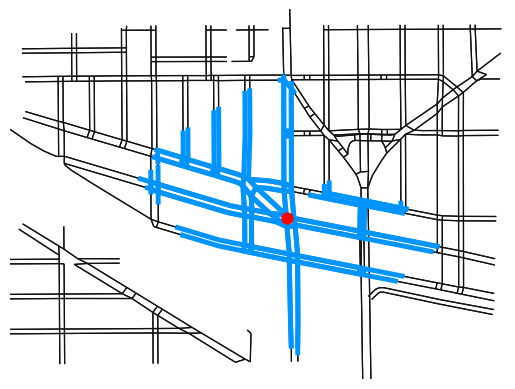

<ggplot: (8743405140487)>

In [12]:
plot = plot_walkshed("fremont")
plot.save("../artifacts/figures/Fig1/figure_framework_walkshed.png", dpi=180)
plot.save("../artifacts/figures/Fig1/figure_framework_walkshed.svg", dpi=180)
plot